# Ensemble parameter combinations and cultivar files

In [1]:
import os
import pandas as pd
import numpy as np
import glob as glob
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from pyDOE import *

# my functions
from funcs import unfold, tup_convert

### Step 1. Create dataframe with all parameters
**these values still need valid ranges from literature** <br/>
Literature-based default values
* phenology
    - juv_leaves: 15-25 (Padilla and Otegui, 2005)
    - **staygreen: 3-8*** (still looking for a literature-based value)
    - rmax_ltir: 0.978 (leaves/day) (Kim et al., 2012)
    - rmax_ltar: 0.53 (leaves/day) (Kim et al., 2012)
        - check out (Padilla and Otegui, 2005) for value range
        - I'm thinking to have LTAR vary based on LTIR (e.g. LTAR = 0.5*LTIR)
    - *** !!!want to add phyllochron to this list**
* morphology
    - LAF: leaf angle factor for corn leaves (1.37) ***still need to take this out to init files, also, what it represents**
    - LM_min: length characteristic of genotype (90 cm) (Fournier and Andrieu, 1998)
* physiology
    - vcm25: 60 µmol/m2s (von Caemmerer, 2000, Table 2)
    - vpm25: 120 µmol/m2s (von Caemmerer, 2000, Table 2), 60 µmol/m2s (Kim et al., 2007, Table 4, Soo says don't use this, caveats in measurements)
    - go: 0.096 (Yang et al., 2009)
    - g1: 10.055 (Yang et al., 2009); Table 1 (Miner et al., 2017): 3.06-3.23 (BB model), 6.502-9.482 (BBL model) 
    - **ref_potential:**
    - Topt: **still need to be taken out to cultivar file**

Some additional online resources:
- https://www.farmprogress.com/story-why-should-know-early-stages-corn-development-9-59528
- https://www.farmprogress.com/corn/number-corn-leaves-provides-insight-maturity
- https://www.pioneer.com/us/agronomy/staging_corn_growth.html

In [2]:
# genetic parameter list
params = ['juv_leaves', 'stayGreen', 'rmax_ltir', 'phyllo', # phenology
          'LM_min', # morphology
#         still need to add LAF
          'Vcmax', 'Vpmax', 'g1', 'ref_potential'] # physiology 

#### ensemble paramter range

In [18]:
param_range = {'juv_leaves': [15, 25],
               'stayGreen': [3,8],
               'rmax_ltir': [0.5, 1.5],
               'phyllo': [2, 4],
               'LM_min': [80, 120],
#               'LAF': [1, 3], - don't think I can tweak this too much, +-15% of 1.37
#                                especially since this doesn't directly correspond to leaf angle
               'Vcmax': [60, 80],
               'Vpmax': [60, 120],
               'g1': [1, 10], 
               'ref_potential': [-4, -1]}
#               'T_opt': [20, 28],

### Step 2. Latin hypercube parameter sampling
Info on this method here: https://pythonhosted.org/pyDOE/randomized.html <br/>
Only execute this code block once, if executed once more, everything will be randomized again

In [19]:
sample = lhs(len(params), samples=100)
df_params = pd.DataFrame(sample, columns=params)

df_parameters = pd.DataFrame()
for i in params: 
    df_parameters[i] = unfold(df_params[i], param_range[i][0], param_range[i][1])
df_parameters.juv_leaves = [round(x) for x in df_parameters.juv_leaves]
df_parameters['rmax_ltar'] = df_parameters.rmax_ltir*0.5
df_parameters = df_parameters.round(2)
#df_parameters.to_csv('/home/disk/eos8/ach315/upscale/inits/param_100.csv', index=False)

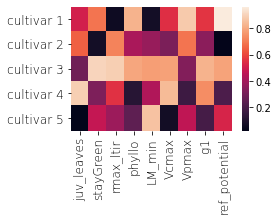

In [20]:
# visualizing parameter spread - this is just an example
sample = lhs(len(params), samples=5) # trying with 5 cultivar combinations for now
df_test = pd.DataFrame(sample, columns=params)
df_test.index = ['cultivar 1','cultivar 2','cultivar 3','cultivar 4','cultivar 5']

fig, ax = plt.subplots(figsize=(4,4))
ax = sns.heatmap(df_test)

plt.xticks(
    fontweight='light', fontsize=12)

plt.yticks(
    rotation=0,
    fontweight='light', fontsize=12)

# adjusting color bar specifics
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)

fig.subplots_adjust(left=0.2, bottom=0.45)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/params.png', format='png', dpi=800, transparent=True)

### Step 3. Creating cultivar init file template
- Main task: create ensemble of parameter files
- Main input: **df_parameters**
- Main output: **/inits/var/var_i.txt**

In [21]:
df_parameters = pd.read_csv('/home/disk/eos8/ach315/upscale/inits/param_100.csv')
df_parameters.head()

,juv_leaves,stayGreen,rmax_ltir,phyllo,LM_min,Vcmax,Vpmax,g1,ref_potential,rmax_ltar
0,21,6.88,0.62,3.20,104.02,60.65,73.10,7.27,-2.11,0.31
1,21,5.35,1.07,3.69,99.54,61.53,75.14,6.72,-3.82,0.54
2,25,3.67,0.88,3.45,97.00,62.34,101.47,4.81,-3.60,0.44
3,25,3.76,1.06,2.49,106.19,77.95,78.45,4.31,-3.34,0.53
4,22,7.58,1.48,2.71,81.69,78.60,117.10,2.21,-1.62,0.74


#### Constant Parameters

In [22]:
# cultivar traits
(daylen_sen) = (0)

# soil water
(rrrm, rrry, rvrl) = (166.7, 31.3, 0.73)
(alpm, alpy, rtwl, rtminwtperunitarea) = (0.35, 0.04, 1.059e-004, 2.0000e-004)
(epsi, lupw, courmax) = (1, 1, 1)
(diffgeo1, diffgeo2, diffgoe3) = (2.4, 2.9, 0)
(wl, wa, wr, wb) = (1, 1, 2, 10)

# soil nitrogen
(isink, rroot) = (0, 0.017)
(consti_1, constk_1, cmin0_1) = (35.0, 0.50, 0.01)
(consti_2, constk_2, cmin0_2) = (17.2, 0.75, 0.30)

# photosynthesis
(eavp, eavc, eaj, hj, sj, jm_25, rd_25, ear, g0) = (75100, 55900, 32800, 220000, 702.6, 300, 2, 39800, 0.017)
(f, scatt, Kc_25, Ko_25, Kp_25, gbs, gi, gamma1) = (0.15, 0.15, 650, 450, 80, 0.003, 1, 0.193)
(gamma_gsw, sf, stoma_ratio, widfct, leaf_wid) = (10.0, 2.3, 1.0, 0.72, 0.05)
(cica_ratio, SC_param, BLC_param) = (0.7, 1.57, 1.36)

In [23]:
# setting up strings
def strings(): 
    tab = '    '
    str1 = '*** Corn growth simulation for US maize simualtion\n'
    str2 = 'cultivar:\n'
    str3 = ('juv_leaf' + tab + 'daylen_sen' + tab + 'staygreen' + tab + 
            'LM_min' + tab + 'Rmax_LTAR' + tab + 'Rmax_LTIR' + tab + 'phyllo\n')
    str4 = '\n'
    str5 = tup_convert(['%.0f' %juv_leaves, tab, '%.0f' %daylen_sen, tab, 
                        '%.2f' %staygreen, tab, '%.f' %LM_min, tab, 
                        '%.2f' %rmax_ltar, tab, '%.2f' %rmax_ltir, tab, '%.0f\n' %phyllo])

    str6 = '[SoilRoot]\n'
    str7 = '*** water uptake parameter information ***\n'
    str8 = 'RRRM' + tab + 'RRRY' + tab + 'RVRL\n'
    str9 = tup_convert(['%.2f' %rrrm, tab, '%.2f' %rrry, tab, '%.2f\n' %rvrl])
    str10 = 'ALPM' + tab + 'ALPY' + tab + 'RTWL' + tab + 'RtMinWtPerUnitArea\n'
    str11 = tup_convert(['%.2f' %alpm, tab, '%.2f' %alpy, tab, '%.7f' %rtwl, tab, '%.4f\n' %rtminwtperunitarea])

    str12 = '[RootDiff]\n'
    str13 = '*** root mover parameter information\n'
    str14 = 'EPSI' + tab + 'lUpW' + tab + 'CourMax\n'
    str15 = tup_convert(['%.f' %epsi, tab, '%.f' %lupw, tab, '%.f\n' %courmax])
    str16 = 'Diffusivity and geotrophic velocity\n'
    str17 = tup_convert(['%.1f' %diffgeo1, tab, '%.1f' %diffgeo2, tab, '%.1f\n' %diffgoe3])

    str18 = '[SoilNitrogen]\n'
    str19 = '*** nitrogen root uptake parameter infromation ***\n'
    str20 = 'ISINK' + tab + 'Rroot\n'
    str21 = tup_convert(['%.0f' %isink, tab, '%.2f\n' %rroot])
    str22 = 'ConstI' + tab + 'Constk' + tab + 'Cmin0\n'
    str23 = tup_convert(['%.1f' %consti_1, tab, '%.1f' %constk_1, tab, '%.2f\n' %cmin0_1])
    str24 = tup_convert(['%.1f' %consti_2, tab, '%.2f' %constk_2, tab, '%.2f\n' %cmin0_2])

    str25 = '[Gas_Exchange Species Parameters]\n'
    str26 = '*** for photosynthesis calculations ***\n'
    str27 = ('EaVP' + tab + 'EaVc' + tab + 'Eaj' + tab + 'Hj' + tab + 'Sj' + tab + 'Vpm25' +
             tab + 'Vcm25' + tab + 'Jm25' + tab + 'Rd25' + tab + 'Ear' + tab + 'g0' + tab + 'g1\n')
    str28 = tup_convert(['%.f' %eavp, tab, '%.f' %eavc, tab, '%.f' %eaj, tab, '%.f' %hj, tab, '%.f' %sj, tab, 
                         '%.f' %vpm_25, tab, '%.f' %vcm_25, tab, '%.f' %jm_25, tab, '%.f' %rd_25, tab,
                         '%.f' %ear, tab, '%.2f' %g0, tab, '%.2f\n' %g1])

    str29 = '*** second set of parameters for photosynthesis ***\n'
    str30 = 'f' + tab + 'scatt' + tab + 'Kc_25' + tab + 'Ko_25' + tab + 'Kp_25' + tab + 'gbs' + tab + 'gi' + tab + 'gamma1\n'
    str31 = tup_convert(['%.2f' %f, tab, '%.2f' %scatt, tab, '%.f' %Kc_25, tab, '%.f' %Ko_25, tab, 
                         '%.f' %Kp_25, tab, '%.3f' %gbs, tab, '%.2f' %gi, tab, '%.2f\n' %gamma1 ])
    
    str32 = '*** third set of photosynthesis parameters ***\n'
    str33 = ('gamma_gsw' + tab + 'sensitivity (sf)' + tab + 'ref_potential (phyla, bars)' + tab + 
            'stoma_ratio' + tab + 'widfct' + tab + 'leaf_wid (m)\n')
    str34 = tup_convert(['%.1f' %gamma_gsw, tab, '%.1f' %sf, tab, '%.1f' %ref_potential, tab, 
                       '%.1f' %stoma_ratio, tab, '%.1f' %widfct, tab, '%.3f\n' %leaf_wid])
    str35 = '**** seconday parameters for miscelanioius equations ****\n'
    str36 = 'Ci/Ca' + tab + 'SC_param' + tab + 'BLC_param\n'
    str37 = tup_convert(['%.1f' %cica_ratio, tab, '%.2f' %SC_param, tab, '%.2f\n' %BLC_param])
    str38 = '[Leaf Parameters]\n'

    # combining strings
    strs = [str1, str2, str3, str4, str5, str6, str7, str8, str9, str10, 
            str11, str12, str13, str14, str15, str16, str17, str18, str19, str20, 
            str21, str22, str23, str24, str25, str26, str27, str28, str29, str30, 
            str31, str32, str33, str34, str35, str36, str37, str38]
    
    return(strs)

In [25]:
# parameter perturbation
for i in np.arange(df_parameters.shape[0]):
    [juv_leaves, staygreen, rmax_ltir, phyllo, LM_min, vcm_25, vpm_25, g1, ref_potential, rmax_ltar] = df_parameters.iloc[i,:]
    strs = strings()
    var = open('/home/disk/eos8/ach315/upscale/inits/var/var_' + str(i) + '.txt', 'w')
    var.writelines(strs)
    var.close()